In [1]:
import warnings
import ast
from pathlib import Path

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import wilcoxon

warnings.filterwarnings("ignore")

In [2]:
PROJECT_NAME = "hbase"
EXP_ID = "apch"
MODEL_HISTORY = 15
TOTAL_WINDOWS = 33
ALPHA = 0.05

DATA_DIR = Path().cwd() / "ecoselekt" / "data"
MODELS_DIR = Path().cwd() / "ecoselekt" / "models"
RESULTS_DIR = Path().cwd() / "results" / f"exp_{EXP_ID}"
FIGURES_DIR = Path().cwd() / "figures"

DATA_DIR.mkdir(parents=True, exist_ok=True)
MODELS_DIR.mkdir(parents=True, exist_ok=True)
RESULTS_DIR.mkdir(parents=True, exist_ok=True)

In [3]:
# load baseline evaluation results
base_eval_df = pd.read_csv(RESULTS_DIR / f"{EXP_ID}_{PROJECT_NAME}_base_eval.csv")
base_eval_df["model"] = "base"
base_eval_df.head()

,project,window,test_split,precision,recall,f1,auc,gmean,ap,specifi,model
0,hbase,0,1,0.810811,0.720000,0.762712,0.783360,0.720000,0.835959,0.720000,base
1,hbase,0,2,0.801802,0.700787,0.747899,0.777155,0.699708,0.810165,0.698630,base
2,hbase,0,3,0.831579,0.686957,0.752381,0.826957,0.746758,0.841827,0.811765,base
3,hbase,0,4,0.903226,0.651163,0.756757,0.815209,0.754070,0.880772,0.873239,base
4,hbase,0,5,0.795455,0.588235,0.676329,0.745617,0.676400,0.778721,0.777778,base


In [4]:
# load ecoselekt evaluation results
selekt_eval_df = pd.read_csv(RESULTS_DIR / f"{EXP_ID}_{PROJECT_NAME}_selekt_eval.csv")
selekt_eval_df["model"] = "ecoselekt"
selekt_eval_df.head()

,project,window,test_split,precision,recall,f1,auc,gmean,ap,specifi,model
0,hbase,15,16,0.758621,0.814815,0.785714,0.860407,0.752880,0.880325,0.695652,ecoselekt
1,hbase,15,17,0.640625,0.845361,0.728889,0.744420,0.683974,0.710692,0.553398,ecoselekt
2,hbase,15,18,0.623932,0.802198,0.701923,0.804265,0.691646,0.808506,0.596330,ecoselekt
3,hbase,15,19,0.577586,0.779070,0.663366,0.732252,0.666488,0.681904,0.570175,ecoselekt
4,hbase,15,20,0.562044,0.895349,0.690583,0.820022,0.651239,0.757653,0.473684,ecoselekt


In [5]:
# load best select evaluation results
best_eval_df = pd.read_csv(RESULTS_DIR / f"{EXP_ID}_{PROJECT_NAME}_best_eval.csv")
best_eval_df["model"] = "best"
best_eval_df.head()

,project,window,test_split,precision,recall,f1,auc,gmean,ap,specifi,model
0,hbase,15,16,0.789474,0.833333,0.810811,0.891103,0.784820,0.910725,0.739130,best
1,hbase,15,17,0.664000,0.855670,0.747748,0.811080,0.711868,0.807556,0.592233,best
2,hbase,15,18,0.638655,0.835165,0.723810,0.851295,0.711123,0.857356,0.605505,best
3,hbase,15,19,0.607143,0.790698,0.686869,0.780702,0.696790,0.747752,0.614035,best
4,hbase,15,20,0.606061,0.930233,0.733945,0.872501,0.711278,0.832723,0.543860,best


(342, 11)


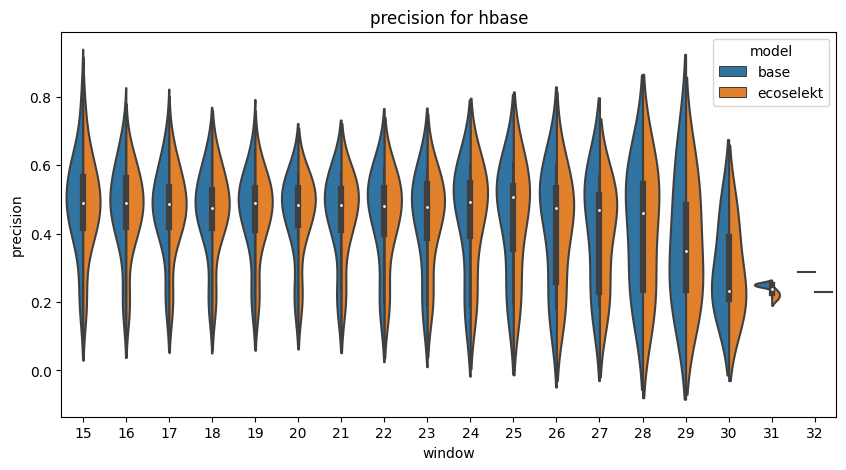

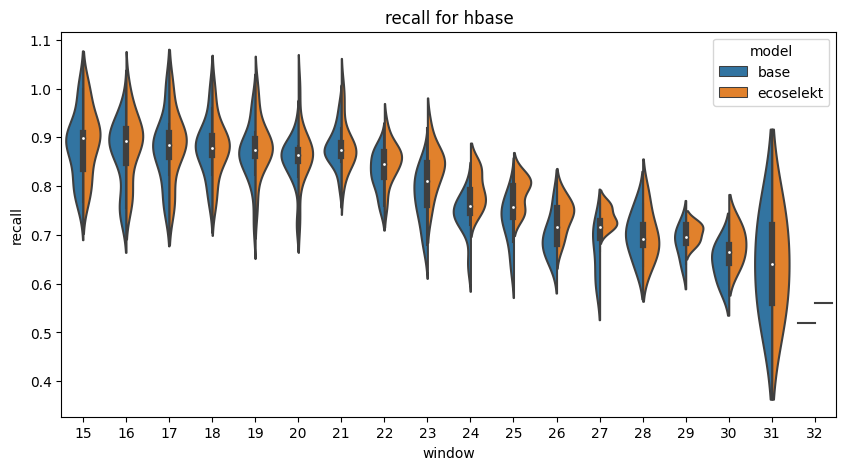

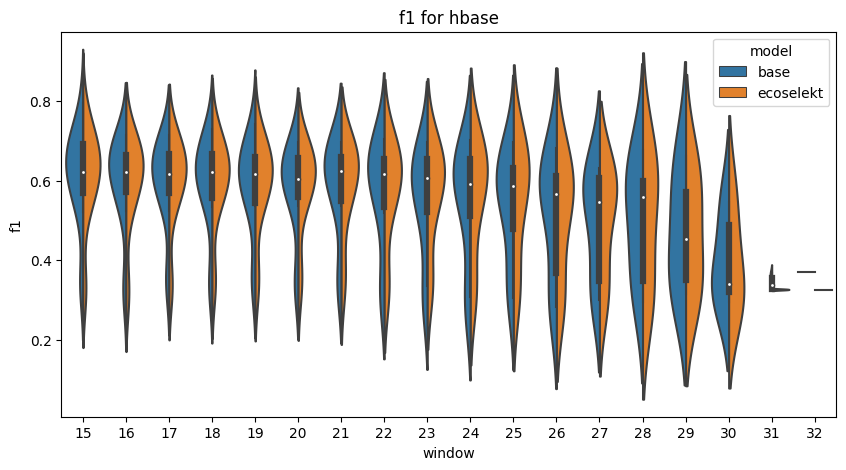

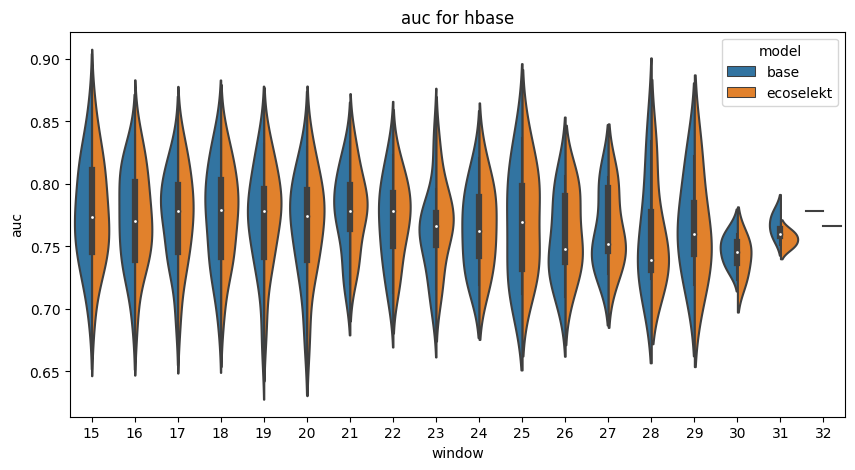

In [6]:
# concat base and ecoselekt evaluation dataframes keeping only common `window` and `test_split` then plot violin plots for each metric
eval_df = pd.concat([base_eval_df[base_eval_df["window"] >= MODEL_HISTORY], selekt_eval_df])
print(eval_df.shape)

# plot violin plots for each metric
for metric in ["precision", "recall", "f1", "auc"]:
    plt.figure(figsize=(10, 5))
    sns.violinplot(x="window", y=metric, data=eval_df, hue="model", split=True)
    plt.title(f"{metric} for {PROJECT_NAME}")
    plt.show()


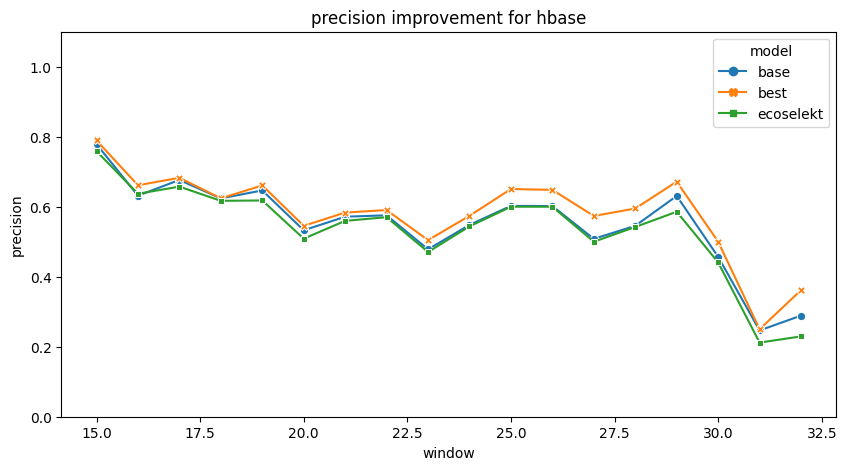

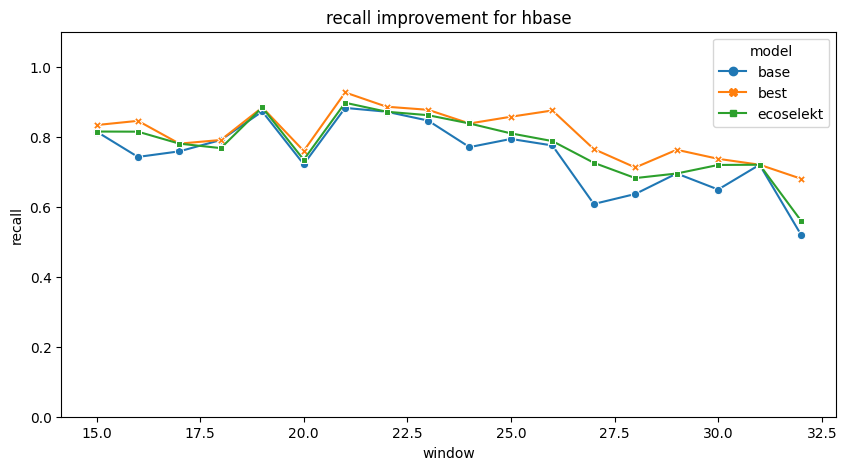

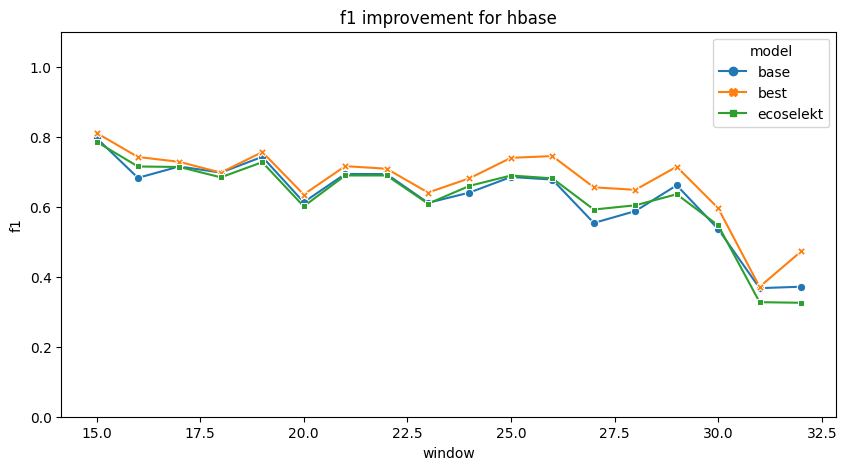

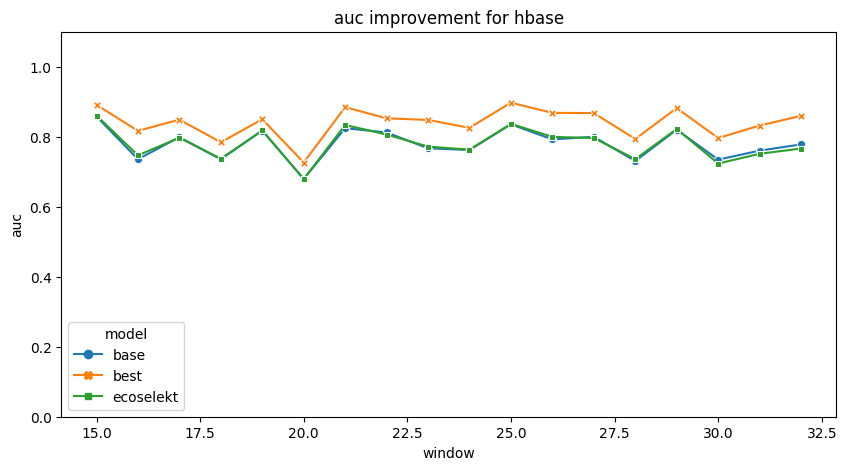

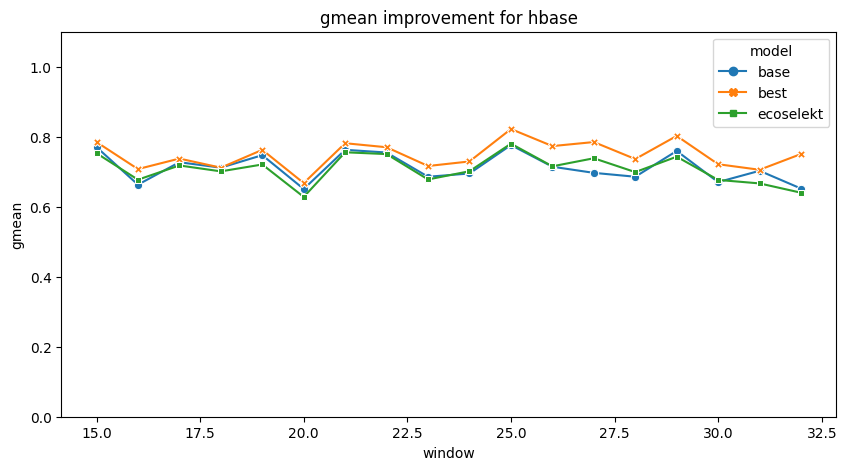

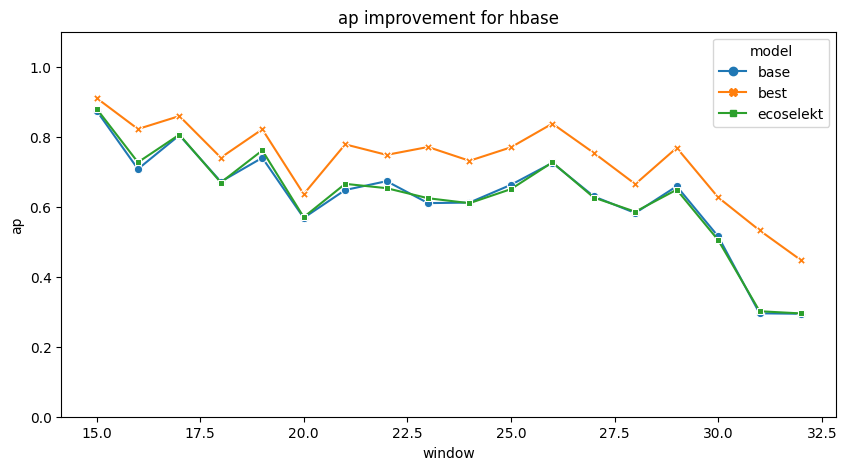

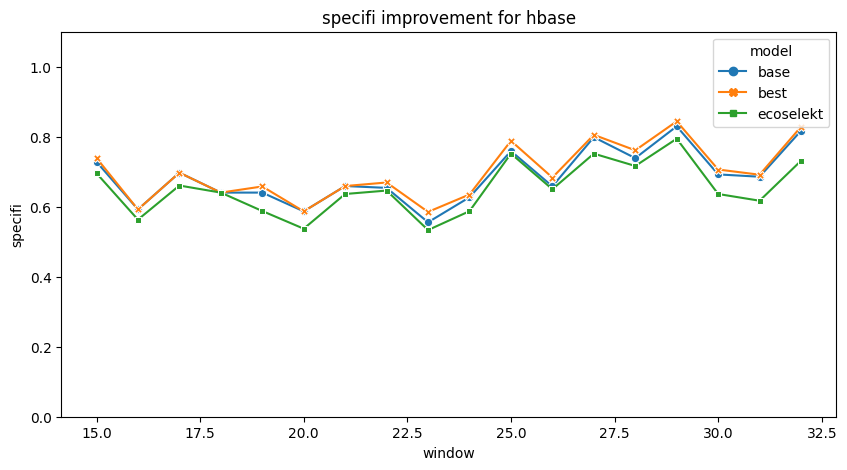

In [7]:
eval_df = pd.concat([base_eval_df[base_eval_df["window"] >= MODEL_HISTORY], best_eval_df, selekt_eval_df])
eval_df = eval_df[eval_df["window"] == eval_df["test_split"] - 1]
# plot percetange improvement for each metric for each window
for metric in ["precision", "recall", "f1", "auc", "gmean", "ap", "specifi"]:
    plt.figure(figsize=(10, 5))
    sns.lineplot(x="window", y=metric, data=eval_df, hue="model", markers=True, style="model", dashes=False)
    plt.title(f"{metric} improvement for {PROJECT_NAME}")
    plt.ylim(0, 1.1)
    plt.show()

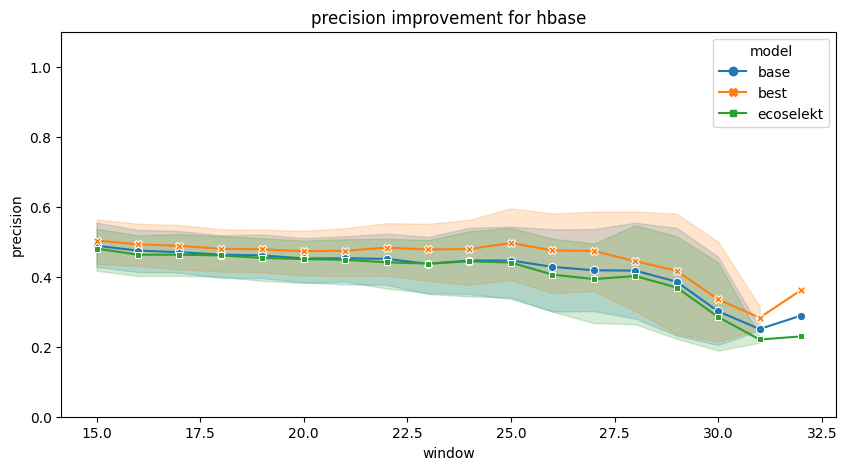

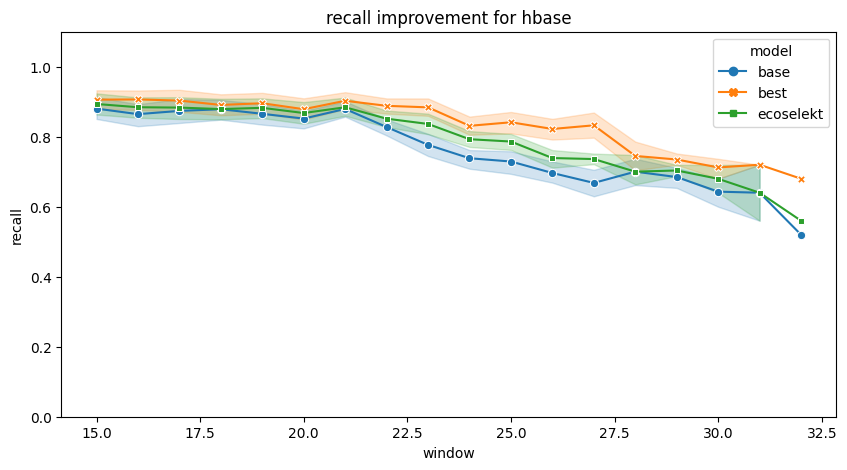

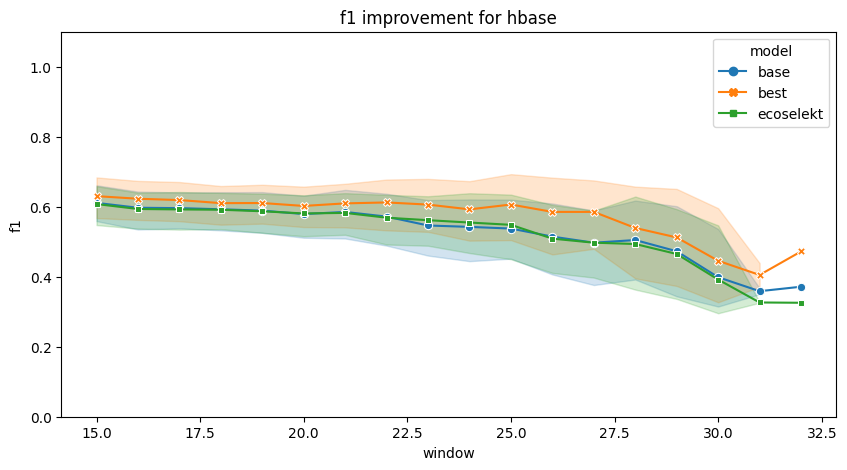

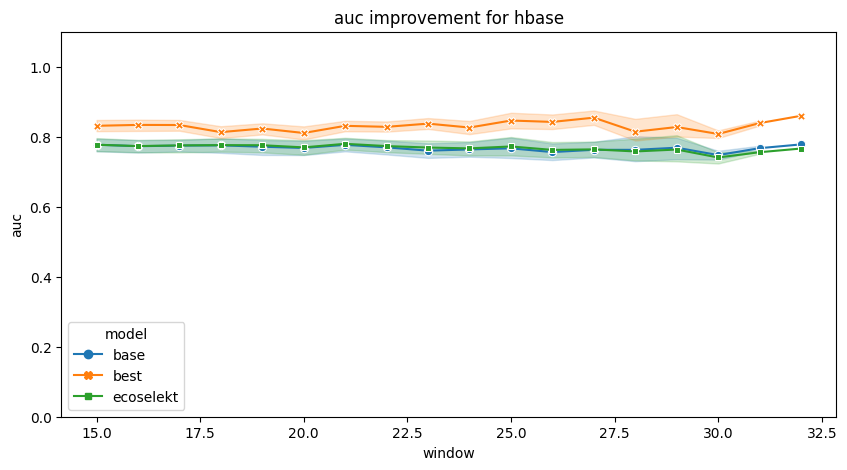

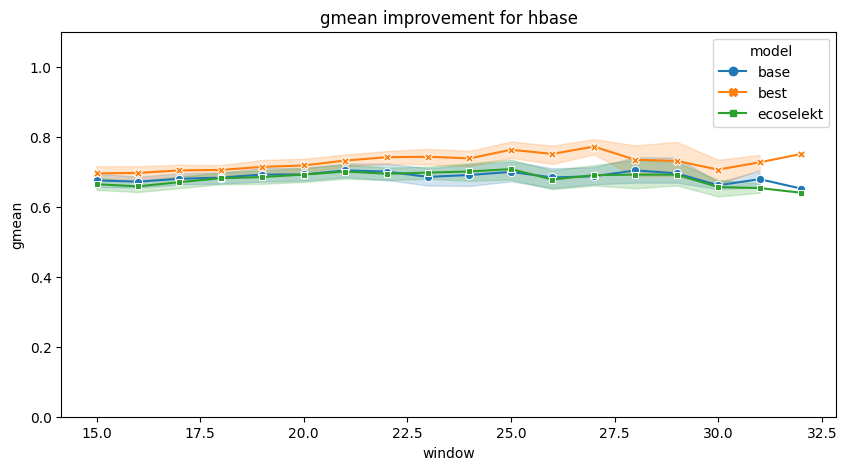

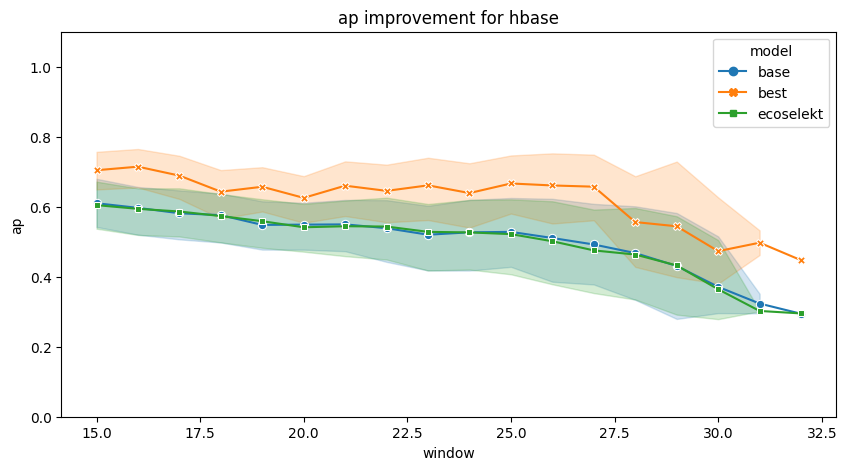

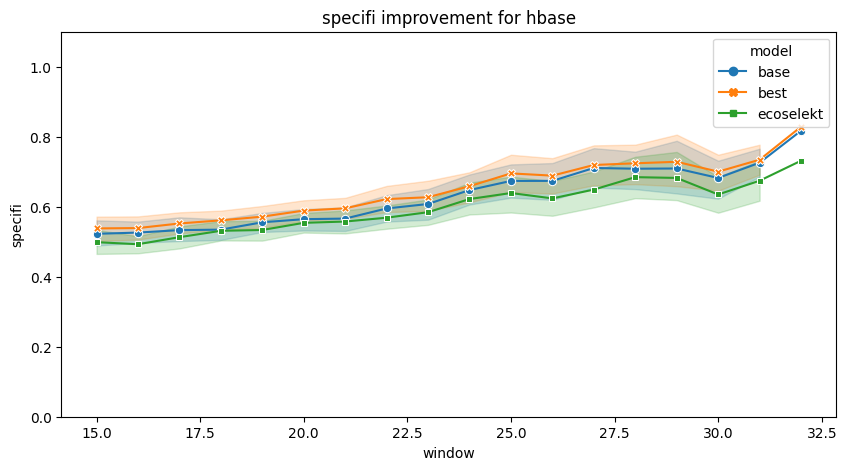

In [8]:
eval_df = pd.concat([base_eval_df[base_eval_df["window"] >= MODEL_HISTORY], best_eval_df, selekt_eval_df])
# plot percetange improvement for each metric for each window
for metric in ["precision", "recall", "f1", "auc", "gmean", "ap", "specifi"]:
    plt.figure(figsize=(10, 5))
    sns.lineplot(x="window", y=metric, data=eval_df, hue="model", markers=True, style="model", dashes=False)
    plt.title(f"{metric} improvement for {PROJECT_NAME}")
    plt.ylim(0, 1.1)
    plt.show()

In [9]:
eval_df = pd.concat([base_eval_df[base_eval_df["window"] >= MODEL_HISTORY], selekt_eval_df])
eval_df = eval_df[eval_df["window"] == eval_df["test_split"] - 1]
_, p = wilcoxon(eval_df[eval_df["model"] == "ecoselekt"]["auc"], eval_df[eval_df["model"] == "base"]["auc"])
print(f"Wilcoxon test p-value: {p}")
print(f"Wilcoxon test significance: {p < ALPHA}")

Wilcoxon test p-value: 0.7337265014648438
Wilcoxon test significance: False


In [10]:
eval_df = pd.concat([base_eval_df[base_eval_df["window"] >= MODEL_HISTORY], selekt_eval_df])
eval_df = eval_df[eval_df["window"] == eval_df["test_split"] - 1]
_, p = wilcoxon(eval_df[eval_df["model"] == "ecoselekt"]["recall"], eval_df[eval_df["model"] == "base"]["recall"])
print(f"Wilcoxon test p-value: {p}")
print(f"Wilcoxon test significance: {p < ALPHA}")

Wilcoxon test p-value: 0.005213241256099401
Wilcoxon test significance: True


In [11]:
bestmodel_df = pd.read_csv(RESULTS_DIR / f"{EXP_ID}_{PROJECT_NAME}_best_model_per_test_split.csv")
bestmodel_df.drop(columns=["Unnamed: 0"], inplace=True)
print(bestmodel_df.shape)
bestmodel_df.head()

(34200, 4)


,commit_id,window,test_split,model_version
0,03d8918142681d4c8abe40e8c8fb32307756d8a8,15,16,10
1,70ecf18817ef219389a9e024ff21ffb99b6615d9,15,16,15
2,3d692cf044bc25327269328933299053ba19e2df,15,16,15
3,47ed5cd7ed0da2976ab6bf10dec3816fa724bd55,15,16,15
4,2b08653a79a8ed0ae8501a110b79f9ea23e808d4,15,16,10


In [12]:
selektmodel_df = pd.read_csv(RESULTS_DIR / f"{EXP_ID}_{PROJECT_NAME}_selected_model_per_test_split.csv")
selektmodel_df.drop(columns=["Unnamed: 0"], inplace=True)
print(selektmodel_df.shape)
selektmodel_df.head()

(55200, 4)


,commit_id,window,test_split,model_version
0,0277f566162f289b1b5c3bab0e34cabf5c8c566c,15,16,15
1,063243c88012241dc24fbcc39de349f49302d79e,15,16,8
2,08bd55aab2c12b136e2b75941f0c4819bab2acef,15,16,15
3,0b0825ad8ef33064e419e6293731a8ce3331894c,15,16,11
4,0b737248c3857966a57cf0af14bd9cf81e9292f7,15,16,15


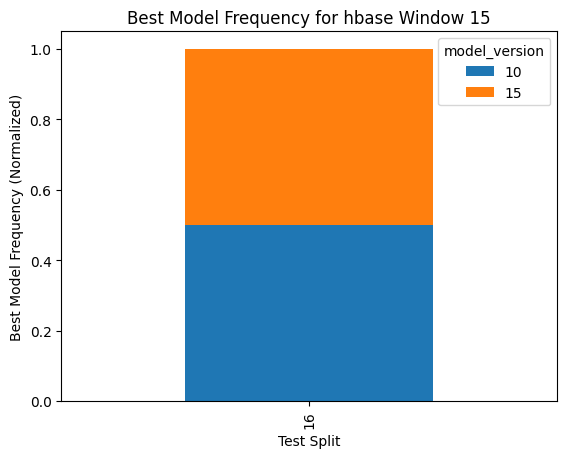

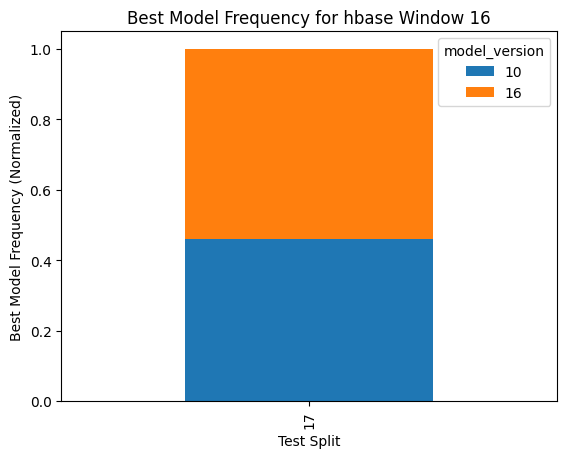

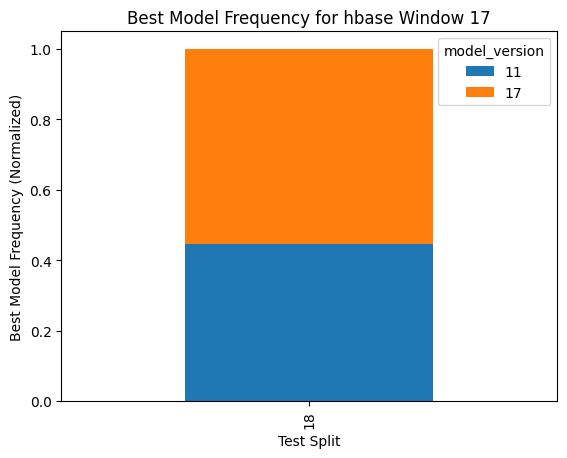

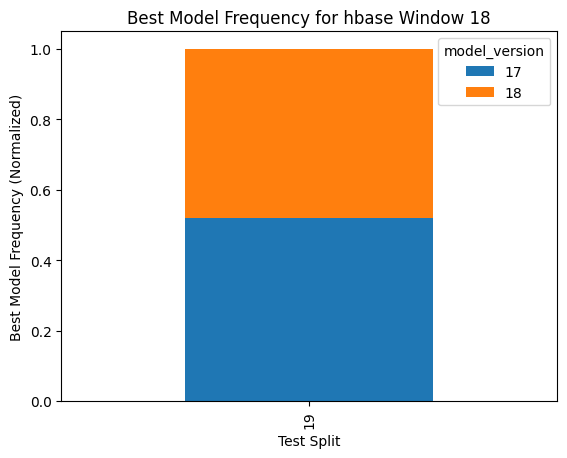

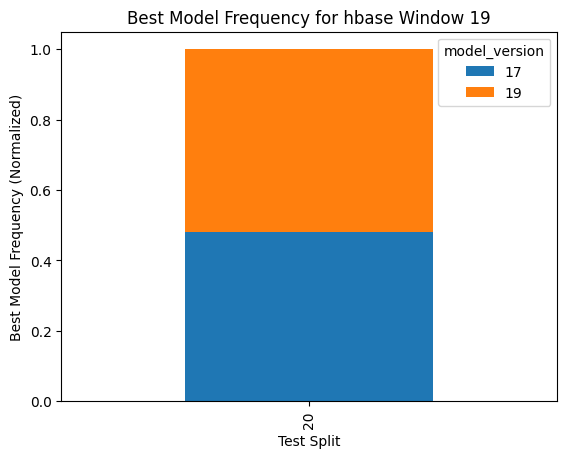

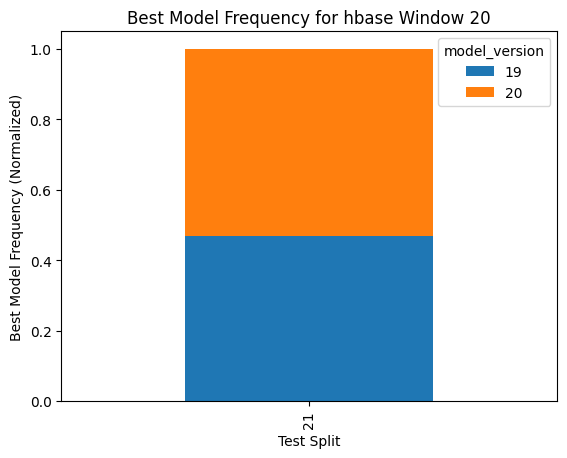

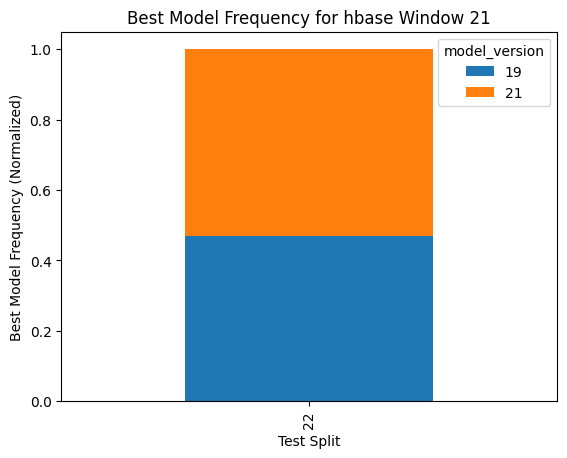

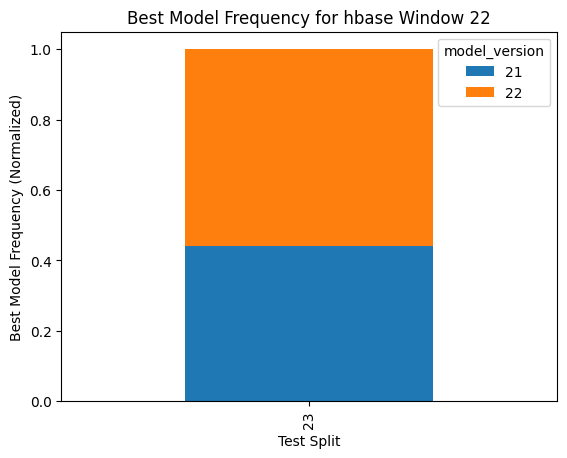

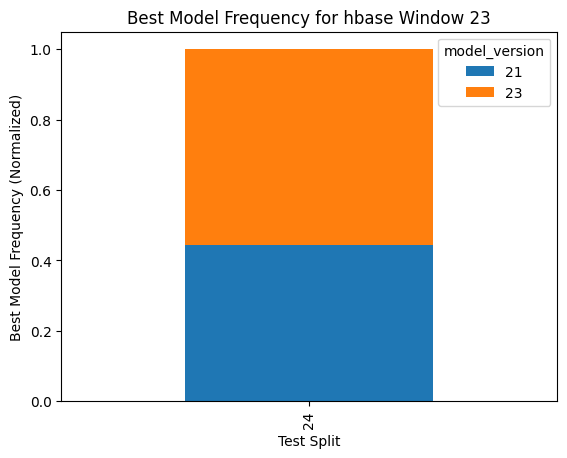

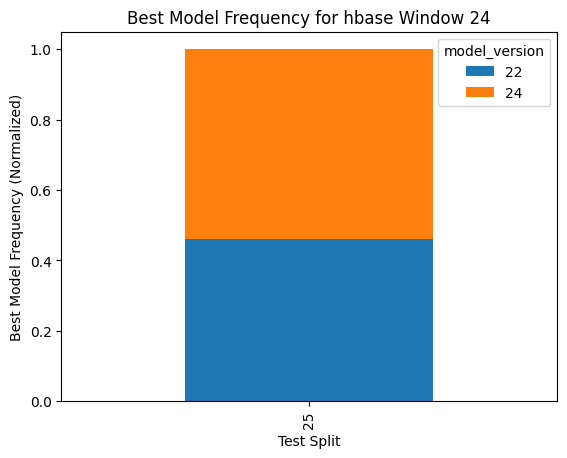

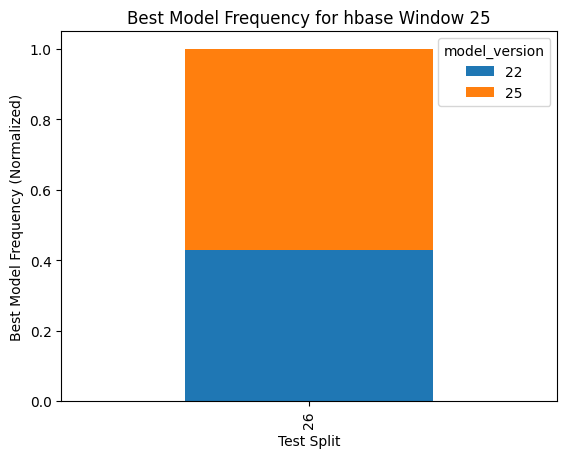

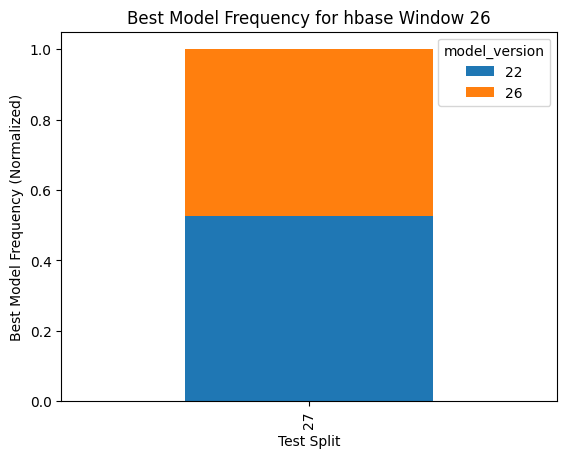

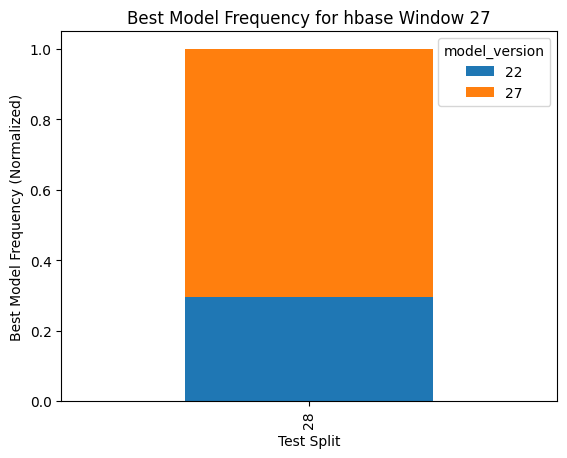

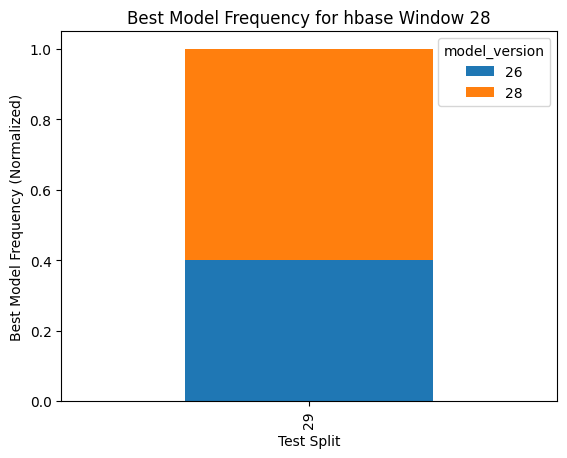

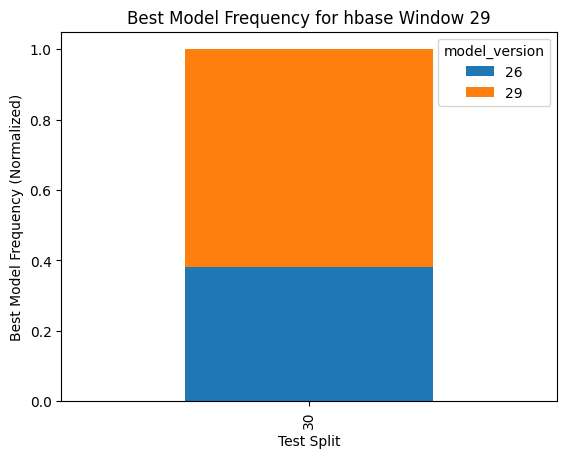

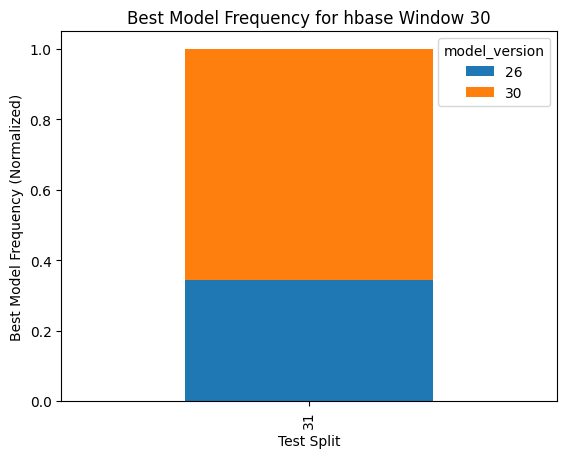

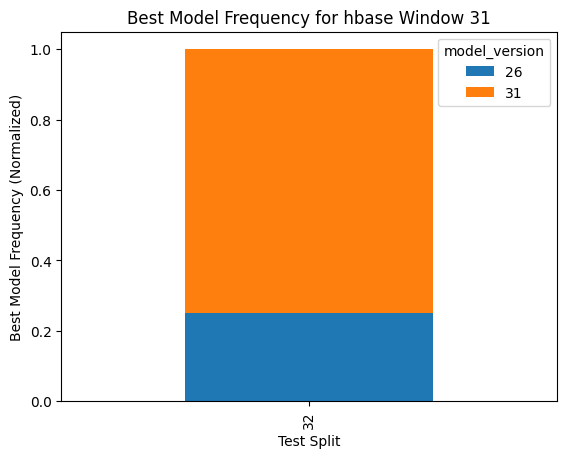

In [13]:
for i in range(MODEL_HISTORY,TOTAL_WINDOWS - 1):
    temp_bestmodel_df = bestmodel_df[bestmodel_df["window"] == i]
    temp_bestmodel_df = temp_bestmodel_df[temp_bestmodel_df["test_split"] == i + 1]

    # best model
    model_frequency_by_test_split = temp_bestmodel_df.groupby('test_split')['model_version'].value_counts().unstack().fillna(0)
    normalized_model_frequency_by_test_split = model_frequency_by_test_split.div(model_frequency_by_test_split.sum(axis=1), axis=0)
    p = normalized_model_frequency_by_test_split.plot(kind='bar', stacked=True)
    p.set_xlabel("Test Split")
    p.set_ylabel("Best Model Frequency (Normalized)")
    p.set_title(f"Best Model Frequency for {PROJECT_NAME} Window {i}")